In [10]:

import numpy as np
import scipy as sp
import scipy.sparse
import pandas as pd
import os
import bbknn

import anndata as ad

import scanpy as sc
import scvi

import matplotlib.pyplot as plt

import hummingbird as hbdx

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# settings
adata_path = "/data/hbdx/test_classifynder/data/LC__ngs__rpm_log-current"
# adata_path = "LC__ngs__rpm__log-current"
n_features = 5000

sc.set_figure_params(figsize=(10,10))
#plt.rcParams['figure.figsize'] = [15,10]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [13]:
def get_data(adata_path, batch_col="Lab_Multiplexing_pool_ID", cell_col=None, condition_col="Diagnosis_Group"):
    adata = hbdx.io.load(adata_path)
    
#     create new column in obs, pool_ID_simple, which is represented in int instead of the pool ID name. 
    pool_id_mapping = {label:f"pool{i}" for i, label in enumerate(adata.obs.Lab_Multiplexing_pool_ID.unique())}
    adata.obs["Lab_Multiplexing_pool_ID_simple"] = adata.obs.Lab_Multiplexing_pool_ID.map(pool_id_mapping)
    
    
    #adata.obs["gender_diagnosis"] = adata.obs.apply(lambda x: x["Gender"]+"__" +x["Diagnosis_Group"], axis=1)
    
#     not sure what/why is happening here, probably to make the column name smaller
    adata.obs["batch"] = adata.obs[batch_col]

#     setting all unknown cell type to blood
    adata.obs["cell_type"] = adata.obs[cell_col] if not cell_col is None else "blood"
    
    #adata.obs["condition"] = adata.obs[condition_col]

    #adata = adata[adata.obs["Sample_Group"]=="Study"].copy()
    
    return adata

def apply_preprocessing(adata, feature_selection=False, n_top_genes=2000):
    adata = adata.copy()
    """
    creates new columns with qc_metrics, removes low count genes, scales data
    and optionally selects highly variable genes
    """
    
#     what is the difference between adata.raw.X and adata.X?
    adata.layers["counts"] = adata.raw.X
    #adata.raw = adata.copy()
    
#     scanpy qc metrics, quality control? for what? I guess it creates new columns like dropout
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    
    sc.pp.scale(adata) # Scale data to unit variance and zero mean.
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes) # Plot dispersions or normalized variance versus means for genes. Documentation vague

    adata = adata[adata.obs.n_genes_by_counts > 5, :] # filtering out low gene count?
    
#     I suppose sc.pp.highly_variable_genes() creates a boolean column called highly_variable in var which you can use to filter. 
# This is not documented at all
    if feature_selection:
        adata = adata[:, adata.var.highly_variable]
#     print(adata.var.highly_variable)
    #sc.tl.pca(adata)
    #sc.pp.neighbors(adata)
    #sc.tl.umap(adata)
    
    #adata.raw = adata
    #adata.layers["log_rpm_scaled"] = adata
    #adata = adata.raw

    return adata

In [14]:
adata = get_data(adata_path,
                #cell_col="Gender"
                )
# Filter out
baddies = ["468_0019_S__210122_468_Pool6", 
           "468_0020_S__210122_468_Pool6",
           "468_0021_S__210122_468_Pool6",
           "468_0022_S__210122_468_Pool6",
           "468_0023_S__210122_468_Pool6",
           "468_0024_S__210122_468_Pool6"]

adata = adata[~adata.obs.index.isin(baddies),:].copy()

print(adata.obs.groupby(["Sequencer","Lab_RNA_extr_protocol"]).batch.value_counts())


Sequencer     Lab_RNA_extr_protocol  batch         
NextSeq_500   QIAsymphony            201209_471_P2     92
                                     201209_471_P3     92
                                     210112_468_P7     79
                                     210128_468_P8     65
                                     201202_468_P3     61
                                                       ..
              manual                 201130_464_P2     48
NextSeq_2000  QIAsymphony            201019_468_P2     58
                                     201029_454I_P1     6
                                     201019_468_P1      4
              manual                 201029_454I_P1    22
Name: batch, Length: 35, dtype: int64


In [15]:
holdout_batches=["GF_Set1", "Konstanz_Pool1", "Thorax_Pool2_D2"] #these do not exist in this dataset?

In [16]:
# print(adata.obs.head())

for i in adata.obs.batch.unique():
    print(i)

holdout_batches=["201123_454A_P3", "201126_454A_P6"]



201123_454A_P3
201126_454A_P6
201120_454A_P2
201123_454A_P4
201120_454A_P1
201126_454A_P5
201204_454I_P3
201029_454I_P1
201204_454I_P2
201201_463_P3
201104_463_P2
201201_463_P4
201103_463_P1
201130_464_P2
201130_464_P1
200720_465_P1
210128_468_P8
210112_468_P7
210111_468_P5
210112_468_P6
201019_468_P2
201202_468_P3
201202_468_P4
210120_471-468_P4
210220_471-468_P5
201019_468_P1
201209_471_P2
201209_471_P3


In [17]:
#split data

# only apply preprocessing to batches NOT in holdout. returns top 5000 features/HVG.
ref_adata = apply_preprocessing(adata[~adata.obs.batch.isin(holdout_batches),:], feature_selection=True, n_top_genes=n_features) 
print(ref_adata.shape)

# Held-out batches without any pre-processing done.
new_adata = adata[adata.obs.batch.isin(holdout_batches), :].copy()
print(new_adata.shape)
new_adata.layers["counts"] = new_adata.raw.X
# filter down the held out data on the HVG determined by the held in data.
# Note, this data is NOT scaled!
new_adata = new_adata[:, ref_adata.var_names].copy()
print(new_adata.shape)



(1673, 5000)
(151, 456553)
(151, 5000)


In [18]:
# Filter out samples with less than count of 1, reduces samples from 1679 to 661!
sc.pp.filter_cells(ref_adata, 
                min_counts=1
                    )
print(ref_adata.shape)

scvi.data.setup_anndata(ref_adata, batch_key="batch", layer="counts", categorical_covariate_keys=["Sequencer", "Lab_RNA_extr_protocol", "Sample_Group", "Gender", "Diagnosis_Group"])

vae = scvi.model.SCVI(ref_adata, n_latent=50)


Trying to set attribute `.obs` of view, copying.
(660, 5000)
INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 660 cells, 5000 vars, 26 batches, 
         1 labels, and 0 proteins. Also registered 5 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [19]:
scvi.data.view_anndata_setup(vae.adata)

Anndata setup with scvi-tools version 0.9.1.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │  660  │
│             Vars             │ 5000  │
│            Labels            │   1   │
│           Batches            │  26   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   5   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │         adata.layers['counts']         │
│ batch_indices │        adata.obs['_scvi_batch']        │
│ local_l_mean  │    adata.obs['_scvi_local_l_mean']     │
│  local_l_var  │     adata.obs['_scvi_local_l_var']     │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                        Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │   200720_465_P1   │          0          │
│                    │   201019_468_P1   │          1          │
│                    │   201019_468_P2   │          2          │
│                    │  201029_454I_P1   │          3          │
│                    │   201103_463_P1   │          4          │
│                    │   201104_463_P2   │          5          │
│                    │  201120_454A_P1   │          6          │
│                    │  201120_454A_P2   │          7          │
│                    │  201123_454A_P4   │          8          │
│                    │  201126_454A_P5   │          9          │
│                    │   201130_464_P1   │         10          │
│                    │   201130_464_P2   │         11          │
│                    │   201201_463_P3   │         12          │
│                    │   201201_463_P4   │         13          │
│                    │   201202_468_P3   │         14          │
│                    │   201202_468_P4   │         15          │
│                    │  201204_454I_P2   │         16          │
│                    │  201204_454I_P3   │         17          │
│                    │   201209_471_P2   │         18          │
│                    │   201209_471_P3   │         19          │
│                    │   210111_468_P5   │         20          │
│                    │   210112_468_P6   │         21          │
│                    │   210112_468_P7   │         22          │
│                    │ 210120_471-468_P4 │         23          │
│                    │   210128_468_P8   │         24          │
│                    │ 210220_471-468_P5 │         25          │
└────────────────────┴───────────────────┴─────────────────────┘

                          Extra Categorical Variables                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃          Source Location           ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│       adata.obs['Sequencer']       │   NextSeq_500    │          0          │
│                                    │   NextSeq_2000   │          1          │
│                                    │                  │                     │
│ adata.obs['Lab_RNA_extr_protocol'] │   QIAsymphony    │          0          │
│                                    │      manual      │          1          │
│                                    │                  │                     │
│     adata.obs['Sample_Group']      │ Standard_control │          0          │
│                                    │      Study       │          1          │
│                                    │                  │                     │
│        adata.obs['Gender']         │      Female      │          0          │
│                                    │       Male       │          1          │
│                                    │       nan        │          2          │
│                                    │                  │                     │
│    adata.obs['Diagnosis_Group']    │      CaseLC      │          0          │
│                                    │    CaseNonLC     │          1          │
│                                    │     Control      │          2          │
│                                    │       nan        │          3          │
│                                    │   unsecured_dx   │          4          │
│                                    │                  │                     │
└────────────────────────────────────┴──────────────────┴─────────────────────┘

In [20]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 18.81it/s, loss=2.09e+03, v_num=1]


In [21]:
#vae.save("scvi_model/")
#vae = scvi.model.SCVI.load("scvi_model/", adata, use_gpu=True)

# del ref_adata.uns["_scvi"]["extra_categoricals"]['n_cats_per_key']

print(ref_adata.uns["_scvi"]["extra_categoricals"])

scvi.data.transfer_anndata_setup(ref_adata, new_adata, extend_categories=True)
# scvi.data.setup_anndata(new_adata, batch_key="batch", layer="counts", categorical_covariate_keys=["Sequencer", "Lab_RNA_extr_protocol", "Sample_Group", "Gender", "Diagnosis_Group"])

# _ = scvi.model.SCVI(new_adata, n_latent=50)
# _.train()

{'mappings': {'Sequencer': array(['NextSeq_500', 'NextSeq_2000'], dtype=object), 'Lab_RNA_extr_protocol': array(['QIAsymphony', 'manual'], dtype=object), 'Sample_Group': array(['Standard_control', 'Study'], dtype=object), 'Gender': array(['Female', 'Male', 'nan'], dtype=object), 'Diagnosis_Group': array(['CaseLC', 'CaseNonLC', 'Control', 'nan', 'unsecured_dx'],
      dtype=object)}, 'keys': ['Sequencer', 'Lab_RNA_extr_protocol', 'Sample_Group', 'Gender', 'Diagnosis_Group'], 'n_cats_per_key': [2, 2, 2, 3, 5]}
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-21-0fd6c7f044df>:8 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scvi/data/_anndata.py:449 in        │
│ transfer_anndata_setup                                                                    │
│                                                                                           │
│    446 │   │   source_cat_dict = _scvi_dict["extra_categoricals"]["mappings"].copy()      │
│    447 │   │   # extend categories                                                        │
│    448 │   │   if extend_categories:                                                      │
│ ❱  449 │   │   │   for key, mapping in source_cat_dict:                                   │
│    450 │   │   │   │   for c in np.unique(adata_target.obs[key]):                         │
│    451 │   │   │   │   │   if c not in mapping:                                           │
│    452 │   │   │   │   │   │   mapping = np.concatenate([mapping, [c]])                   │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: too many values to unpack (expected 2)

In [22]:
latent = vae.get_latent_representation(new_adata)

print(latent)
scvi.data.setup_anndata(new_adata, batch_key="batch", layer="counts", categorical_covariate_keys=["Sequencer", "Lab_RNA_extr_protocol", "Sample_Group", "Gender", "Diagnosis_Group"])

vae_new_data = scvi.model.SCVI.load_query_data(new_adata, vae)

vae_new_data.train(max_epochs=0, plan_kwargs=dict(weight_decay=0.0))


laten_predictedt = vae_new_data.get_latent_representation()
latent_control = vae_new_data.get_latent_representation(latent)

# OKAY, so if you want to do inference, you need to re-initialize the VAE with the new data. 
print(latent.shape, predicted_latents.shape)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-22-b86953ee3568>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/torch/autograd/grad_mode.py:27 in   │
│ decorate_context                                                                          │
│                                                                                           │
│    24 │   │   @functools.wraps(func)                                                      │
│    25 │   │   def decorate_context(*args, **kwargs):                                      │
│    26 │   │   │   with self.__class__():                                                  │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                        │
│    28 │   │   return cast(F, decorate_context)                                            │
│    29 │                                                                                   │
│    30 │   def _wrap_generator(self, func):                                                │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scvi/model/base/_vaemixin.py:158 in │
│ get_latent_representation                                                                 │
│                                                                                           │
│   155 │   │   if self.is_trained_ is False:                                               │
│   156 │   │   │   raise RuntimeError("Please train the model first.")                     │
│   157 │   │                                                                               │
│ ❱ 158 │   │   adata = self._validate_anndata(adata)                                       │
│   159 │   │   scdl = self._make_data_loader(                                              │
│   160 │   │   │   adata=adata, indices=indices, batch_size=batch_size                     │
│   161 │   │   )                                                                           │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scvi/model/base/_base_model.py:143  │
│ in _validate_anndata                                                                      │
│                                                                                           │
│   140 │   │   │   )                                                                       │
│   141 │   │   │   transfer_anndata_setup(self.scvi_setup_dict_, adata)                    │
│   142 │   │   is_nonneg_int = _check_nonnegative_integers(                                │
│ ❱ 143 │   │   │   get_from_registry(adata, _CONSTANTS.X_KEY)                              │
│   144 │   │   )                                                                           │
│   145 │   │   if not is_nonneg_int:                                                       │
│   146 │   │   │   logger.warning(                                                         │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scvi/data/_anndata.py:65 in         │
│ get_from_registry                                                                         │
│                                                                                           │
│     62 │   │      [0],                                                                    │
│     63 │   │      [0]])                                                                   │
│     64 │   """                                                                            │
│ ❱   65 │   data_loc = adata.uns["_scvi"]["data_reg

In [23]:
# ref_adata.obsm["X_scVI"] = latent
# ref_adata.obsm["X_pca"] = latent

print(new_adata.uns["_scvi"].keys())
print(new_adata.uns["_scvi"]['categorical_mappings'])


print(ref_adata.uns["_scvi"]['data_registry'].keys())
print(ref_adata.uns["_scvi"]["extra_categoricals"].keys())



dict_keys(['scvi_version', 'categorical_mappings'])
{'_scvi_batch': {'original_key': 'batch', 'mapping': array(['200720_465_P1', '201019_468_P1', '201019_468_P2',
       '201029_454I_P1', '201103_463_P1', '201104_463_P2',
       '201120_454A_P1', '201120_454A_P2', '201123_454A_P4',
       '201126_454A_P5', '201130_464_P1', '201130_464_P2',
       '201201_463_P3', '201201_463_P4', '201202_468_P3', '201202_468_P4',
       '201204_454I_P2', '201204_454I_P3', '201209_471_P2',
       '201209_471_P3', '210111_468_P5', '210112_468_P6', '210112_468_P7',
       '210120_471-468_P4', '210128_468_P8', '210220_471-468_P5',
       '201123_454A_P3', '201126_454A_P6'], dtype=object)}, '_scvi_labels': {'original_key': '_scvi_labels', 'mapping': array([0])}}
dict_keys(['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels', 'cat_covs'])
dict_keys(['mappings', 'keys', 'n_cats_per_key'])


In [24]:
# sc.pp.pca(ref_adata)
# sc.pp.neighbors(ref_adata)


sc.pp.neighbors(ref_adata, use_rep="X_scVI"  )
# sc.pp.neighbors(ref_adata, use_rep="X_pca", n_neighbors=10)
sc.tl.umap(ref_adata)

print(ref_adata.obsm)

# print(ref_adata.obsm["X_scVI"].shape, ref_adata.obsm["X_pca"].shape)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-24-60f18df7ff94>:5 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:139 in │
│ neighbors                                                                                 │
│                                                                                           │
│    136 │   if adata.is_view:  # we shouldn't need this here...                            │
│    137 │   │   adata._init_as_actual(adata.copy())                                        │
│    138 │   neighbors = Neighbors(adata)                                                   │
│ ❱  139 │   neighbors.compute_neighbors(                                                   │
│    140 │   │   n_neighbors=n_neighbors,                                                   │
│    141 │   │   knn=knn,                                                                   │
│    142 │   │   n_pcs=n_pcs,                                                               │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:770 in │
│ compute_neighbors                                                                         │
│                                                                                           │
│    767 │   │   self._rp_forest = None                                                     │
│    768 │   │   self.n_neighbors = n_neighbors                                             │
│    769 │   │   self.knn = knn                                                             │
│ ❱  770 │   │   X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)      │
│    771 │   │   # neighbor search                                                          │
│    772 │   │   use_dense_distances = (metric == 'euclidean' and X.shape[0] < 8192) or not │
│    773 │   │   if use_dense_distances:                                                    │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_utils.py:57 in        │
│ _choose_representation                                                                    │
│                                                                                           │
│    54 │   │   elif use_rep == 'X':                                                        │
│    55 │   │   │   X = adata.X                                                             │
│    56 │   │   else:                                                                       │
│ ❱  57 │   │   │   raise ValueError(                                                       │
│    58 │   │   │   │   'Did not find {} in `.obsm.keys()`. '                               │
│    59 │   │   │   │   'You need to compute it first.'.format(use_rep)                     │
│    60 │   │   │   )                                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Did not find X_scVI in `.obsm.keys()`. You need to compute it first.

In [25]:
sc.pl.umap(ref_adata, color=["Sample_Group", "Lab_Multiplexing_pool_ID", "Diagnosis_Group", "ProjectName","Gender","Sequencer","ColDevice_Weight", "Lab_RNA_extr_protocol", "RIN","Lab_Blocking_Protocol","Lab_Library_Purification" ,"Site_Measurement", "TumStageSimp", "Diagnosis_Group_sub", "Age", "Packyears", "Ethnicity", "Lab_Library_Protocol",  "FlowCell_nr_of_flow_cells" ],    ncols=3, use_raw=False, )

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-25-0111e030ec74>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots │
│ .py:603 in umap                                                                           │
│                                                                                           │
│    600 │   -------                                                                        │
│    601 │   If `show==False` a :class:`~matplotlib.axes.Axes` or a list of it.             │
│    602 │   """                                                                            │
│ ❱  603 │   return embedding(adata, 'umap', **kwargs)                                      │
│    604                                                                                    │
│    605                                                                                    │
│    606 @_wraps_plot_scatter                                                               │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots │
│ .py:167 in embedding                                                                      │
│                                                                                           │
│    164 │                                                                                  │
│    165 │   # get the points position and the components list                              │
│    166 │   # (only if components is not None)                                             │
│ ❱  167 │   data_points, components_list = _get_data_points(                               │
│    168 │   │   adata, basis, projection, components, scale_factor                         │
│    169 │   )                                                                              │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots │
│ .py:914 in _get_data_points                                                               │
│                                                                                           │
│    911 │   elif f"X_{basis}" in adata.obsm.keys():                                        │
│    912 │   │   basis_key = f"X_{basis}"                                                   │
│    913 │   else:                                                                          │
│ ❱  914 │   │   raise KeyError(                                                            │
│    915 │   │   │   f"Could not find entry in `obsm` for '{basis}'.\n"                     │
│    916 │   │   │   f"Available keys are: {list(adata.obsm.keys())}."                      │
│    917 │   │   )                                                                          │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: 
['_scvi_extra_categoricals']."

In [26]:
print(new_adata.shape, ref_adata.shape)
print(new_adata.X.shape, ref_adata.X.shape)
print(new_adata.layers["counts"].shape, ref_adata.layers["counts"].shape)

# sc.tl.ingest = Map labels and embeddings from reference data to new data.

new_adata_mapped = sc.tl.ingest(new_adata, ref_adata, inplace=False, embedding_method='umap')

(151, 5000) (660, 5000)
(151, 5000) (660, 5000)
(151, 5000) (660, 5000)


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-26-ea59da4cce42>:7 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_ingest.py:126 in      │
│ ingest                                                                                    │
│                                                                                           │
│   123 │   if len(labeling_method) == 1 and len(obs or []) > 1:                            │
│   124 │   │   labeling_method = labeling_method * len(obs)                                │
│   125 │                                                                                   │
│ ❱ 126 │   ing = Ingest(adata_ref, neighbors_key)                                          │
│   127 │   ing.fit(adata)                                                                  │
│   128 │                                                                                   │
│   129 │   for method in embedding_method:                                                 │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_ingest.py:387 in      │
│ __init__                                                                                  │
│                                                                                           │
│   384 │   │   if neighbors_key in adata.uns:                                              │
│   385 │   │   │   self._init_neighbors(adata, neighbors_key)                              │
│   386 │   │   else:                                                                       │
│ ❱ 387 │   │   │   raise ValueError(                                                       │
│   388 │   │   │   │   f'There is no neighbors data in `adata.uns["{neighbors_key}"]`.\n'  │
│   389 │   │   │   │   'Please run pp.neighbors.'                                          │
│   390 │   │   │   )                                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: There is no neighbors data in `adata.uns["neighbors"]`.
Please run pp.neighbors.

In [27]:
distances = ref_adata.uns['neighbors']['distances']
n_neighbors = 15
for j, i in enumerate(distances.tolil().rows):
    
    if len(i) == n_neighbors-1:
        pass
    else:
        print(j, i)



╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-27-1f5749c8cb58>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 98 in __getitem__                                                                         │
│                                                                                           │
│    95 │                                                                                   │
│    96 │   def __getitem__(self, key):                                                     │
│    97 │   │   if key in self.overloaded:                                                  │
│ ❱  98 │   │   │   return self.overloaded[key].get()                                       │
│    99 │   │   else:                                                                       │
│   100 │   │   │   return self.data[key]                                                   │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 185 in _neighbors_getter                                                                  │
│                                                                                           │
│   182 def _neighbors_getter(ovld: OverloadedDict, key, adata: "AnnData"):                 │
│   183 │   """For overloading: `adata.uns["neighbors"]`"""                                 │
│   184 │   return OverloadedDict(                                                          │
│ ❱ 185 │   │   ovld.data[key],                                                             │
│   186 │   │   overloaded={                                                                │
│   187 │   │   │   "connectivities": KeyOverload(                                          │
│   188 │   │   │   │   "connectivities",                                                   │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'neighbors'

In [28]:
print(new_adata.obs.shape, ref_adata.obs.shape)

print(new_adata.var.shape, ref_adata.var.shape)

print(new_adata.var_names.symmetric_difference(ref_adata.var_names))

print(ref_adata.uns['neighbors'])

# print(ref_adata.obsp['distances'])

# print(ref_adata.uns['neighbors']['distances'])

(151, 137) (660, 146)
(5000, 42) (5000, 54)
Index([], dtype='object')


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-28-bc45119f42d4>:7 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 98 in __getitem__                                                                         │
│                                                                                           │
│    95 │                                                                                   │
│    96 │   def __getitem__(self, key):                                                     │
│    97 │   │   if key in self.overloaded:                                                  │
│ ❱  98 │   │   │   return self.overloaded[key].get()                                       │
│    99 │   │   else:                                                                       │
│   100 │   │   │   return self.data[key]                                                   │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 185 in _neighbors_getter                                                                  │
│                                                                                           │
│   182 def _neighbors_getter(ovld: OverloadedDict, key, adata: "AnnData"):                 │
│   183 │   """For overloading: `adata.uns["neighbors"]`"""                                 │
│   184 │   return OverloadedDict(                                                          │
│ ❱ 185 │   │   ovld.data[key],                                                             │
│   186 │   │   overloaded={                                                                │
│   187 │   │   │   "connectivities": KeyOverload(                                          │
│   188 │   │   │   │   "connectivities",                                                   │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'neighbors'

In [29]:
merged_adata = ref_adata.concatenate(new_adata_mapped)

sc.pl.umap(merged_adata , color=[ "Sample_Group","Lab_Multiplexing_pool_ID", "Diagnosis_Group", "Sequencer","Lab_RNA_extr_protocol" ], ncols=2, use_raw=False, )

sc.pl.umap(merged_adata , color=["Lab_Multiplexing_pool_ID"], groups=holdout_batches, ncols=2, use_raw=False, )

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-29-a69166fd67aa>:1 in <module>                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'new_adata_mapped' is not defined

In [30]:
print("ref_adata")

for i in ref_adata.obsm:
    print(i)

print("new_adata")

for i in new_adata.obsm:
    print(i)

ref_adata
_scvi_extra_categoricals
new_adata


In [31]:
print(ref_adata.obsm["X_scVI"].shape) # 10-dim latent representation of the 661 samples.
print(ref_adata.obsm["X_pca"].shape)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-31-6e0bac24cf11>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/_core/aligned_mapping.py:14 │
│ 8 in __getitem__                                                                          │
│                                                                                           │
│   145 │   is_view = False                                                                 │
│   146 │                                                                                   │
│   147 │   def __getitem__(self, key: str) -> V:                                           │
│ ❱ 148 │   │   return self._data[key]                                                      │
│   149 │                                                                                   │
│   150 │   def __setitem__(self, key: str, value: V):                                      │
│   151 │   │   value = self._validate_value(value, key)                                    │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'X_scVI'

In [32]:
ref_adata.uns["neighbors"]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-32-c7846ceaa323>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 98 in __getitem__                                                                         │
│                                                                                           │
│    95 │                                                                                   │
│    96 │   def __getitem__(self, key):                                                     │
│    97 │   │   if key in self.overloaded:                                                  │
│ ❱  98 │   │   │   return self.overloaded[key].get()                                       │
│    99 │   │   else:                                                                       │
│   100 │   │   │   return self.data[key]                                                   │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 185 in _neighbors_getter                                                                  │
│                                                                                           │
│   182 def _neighbors_getter(ovld: OverloadedDict, key, adata: "AnnData"):                 │
│   183 │   """For overloading: `adata.uns["neighbors"]`"""                                 │
│   184 │   return OverloadedDict(                                                          │
│ ❱ 185 │   │   ovld.data[key],                                                             │
│   186 │   │   overloaded={                                                                │
│   187 │   │   │   "connectivities": KeyOverload(                                          │
│   188 │   │   │   │   "connectivities",                                                   │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'neighbors'

In [33]:

# var_names = adata_ref.var_names.intersection(adata.var_names) #only take overlapping features
# adata_ref = adata_ref[:, var_names]
# adata = adata[:, var_names]

# print(adata.shape, adata_ref.shape)


In [34]:
distances = ref_adata.uns['neighbors']['distances']

first_col = np.arange(distances.shape[0])[:, None]
# print(first_col)
init_indices = np.hstack((first_col, np.stack(distances.tolil().rows)))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-34-6b03380a8d1e>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 98 in __getitem__                                                                         │
│                                                                                           │
│    95 │                                                                                   │
│    96 │   def __getitem__(self, key):                                                     │
│    97 │   │   if key in self.overloaded:                                                  │
│ ❱  98 │   │   │   return self.overloaded[key].get()                                       │
│    99 │   │   else:                                                                       │
│   100 │   │   │   return self.data[key]                                                   │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py: │
│ 185 in _neighbors_getter                                                                  │
│                                                                                           │
│   182 def _neighbors_getter(ovld: OverloadedDict, key, adata: "AnnData"):                 │
│   183 │   """For overloading: `adata.uns["neighbors"]`"""                                 │
│   184 │   return OverloadedDict(                                                          │
│ ❱ 185 │   │   ovld.data[key],                                                             │
│   186 │   │   overloaded={                                                                │
│   187 │   │   │   "connectivities": KeyOverload(                                          │
│   188 │   │   │   │   "connectivities",                                                   │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'neighbors'

In [35]:
n_neighbors = 11

sc.pp.neighbors(ref_adata, use_rep="X_pca", n_neighbors=n_neighbors)
distances = ref_adata.uns['neighbors']['distances']

for j, i in enumerate(distances.tolil().rows):
    
    if len(i) == n_neighbors-1:
        pass
    else:
        print(j, i)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-35-324554745d6b>:3 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:139 in │
│ neighbors                                                                                 │
│                                                                                           │
│    136 │   if adata.is_view:  # we shouldn't need this here...                            │
│    137 │   │   adata._init_as_actual(adata.copy())                                        │
│    138 │   neighbors = Neighbors(adata)                                                   │
│ ❱  139 │   neighbors.compute_neighbors(                                                   │
│    140 │   │   n_neighbors=n_neighbors,                                                   │
│    141 │   │   knn=knn,                                                                   │
│    142 │   │   n_pcs=n_pcs,                                                               │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:770 in │
│ compute_neighbors                                                                         │
│                                                                                           │
│    767 │   │   self._rp_forest = None                                                     │
│    768 │   │   self.n_neighbors = n_neighbors                                             │
│    769 │   │   self.knn = knn                                                             │
│ ❱  770 │   │   X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)      │
│    771 │   │   # neighbor search                                                          │
│    772 │   │   use_dense_distances = (metric == 'euclidean' and X.shape[0] < 8192) or not │
│    773 │   │   if use_dense_distances:                                                    │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_utils.py:57 in        │
│ _choose_representation                                                                    │
│                                                                                           │
│    54 │   │   elif use_rep == 'X':                                                        │
│    55 │   │   │   X = adata.X                                                             │
│    56 │   │   else:                                                                       │
│ ❱  57 │   │   │   raise ValueError(                                                       │
│    58 │   │   │   │   'Did not find {} in `.obsm.keys()`. '                               │
│    59 │   │   │   │   'You need to compute it first.'.format(use_rep)                     │
│    60 │   │   │   )                                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Did not find X_pca in `.obsm.keys()`. You need to compute it first.

In [36]:
for i in [441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455]:
    print(ref_adata.obs.index[i])


468_0009_S__210128_468_Pool4
468_0014_2__210122_468_Pool6
468_0015_2__210122_468_Pool6
468_0015_S__HBDx_2021_01
468_0017__210122_468_Pool6
468_0018_S__HBDx_2021_01
468_0019__210122_468_Pool6
468_0020__210122_468_Pool6
468_0021__210122_468_Pool6
468_0022__210122_468_Pool6
468_0023__210122_468_Pool6
468_0024__210122_468_Pool6
468_0029_2__210122_468_Pool6
468_0030_2__210122_468_Pool6
468_0031__210122_468_Pool6


In [37]:
to_drop = [ref_adata.obs.iloc[x].name for x in [445, 446, 447, 448, 449, 450, 451, 452, 453, 454]]

In [38]:
print(ref_adata.obs.shape)
dropped = ref_adata[~ref_adata.obs.index.isin(to_drop),:]

print(dropped.obs.shape)

(660, 146)
(650, 146)


In [39]:
sc.pp.neighbors(dropped, use_rep="X_pca"  )
# sc.pp.neighbors(ref_adata, use_rep="X_pca", n_neighbors=10)
sc.tl.umap(dropped)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-39-aadac6fe9655>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:139 in │
│ neighbors                                                                                 │
│                                                                                           │
│    136 │   if adata.is_view:  # we shouldn't need this here...                            │
│    137 │   │   adata._init_as_actual(adata.copy())                                        │
│    138 │   neighbors = Neighbors(adata)                                                   │
│ ❱  139 │   neighbors.compute_neighbors(                                                   │
│    140 │   │   n_neighbors=n_neighbors,                                                   │
│    141 │   │   knn=knn,                                                                   │
│    142 │   │   n_pcs=n_pcs,                                                               │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:770 in │
│ compute_neighbors                                                                         │
│                                                                                           │
│    767 │   │   self._rp_forest = None                                                     │
│    768 │   │   self.n_neighbors = n_neighbors                                             │
│    769 │   │   self.knn = knn                                                             │
│ ❱  770 │   │   X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)      │
│    771 │   │   # neighbor search                                                          │
│    772 │   │   use_dense_distances = (metric == 'euclidean' and X.shape[0] < 8192) or not │
│    773 │   │   if use_dense_distances:                                                    │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_utils.py:57 in        │
│ _choose_representation                                                                    │
│                                                                                           │
│    54 │   │   elif use_rep == 'X':                                                        │
│    55 │   │   │   X = adata.X                                                             │
│    56 │   │   else:                                                                       │
│ ❱  57 │   │   │   raise ValueError(                                                       │
│    58 │   │   │   │   'Did not find {} in `.obsm.keys()`. '                               │
│    59 │   │   │   │   'You need to compute it first.'.format(use_rep)                     │
│    60 │   │   │   )                                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Did not find X_pca in `.obsm.keys()`. You need to compute it first.

In [40]:
new_adata_mapped = sc.tl.ingest(new_adata, dropped, inplace=False, embedding_method='umap')

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-40-10149c3ee00e>:1 in <module>                                             │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_ingest.py:126 in      │
│ ingest                                                                                    │
│                                                                                           │
│   123 │   if len(labeling_method) == 1 and len(obs or []) > 1:                            │
│   124 │   │   labeling_method = labeling_method * len(obs)                                │
│   125 │                                                                                   │
│ ❱ 126 │   ing = Ingest(adata_ref, neighbors_key)                                          │
│   127 │   ing.fit(adata)                                                                  │
│   128 │                                                                                   │
│   129 │   for method in embedding_method:                                                 │
│                                                                                           │
│ /home/mah/conda/envs/hbdx/lib/python3.8/site-packages/scanpy/tools/_ingest.py:387 in      │
│ __init__                                                                                  │
│                                                                                           │
│   384 │   │   if neighbors_key in adata.uns:                                              │
│   385 │   │   │   self._init_neighbors(adata, neighbors_key)                              │
│   386 │   │   else:                                                                       │
│ ❱ 387 │   │   │   raise ValueError(                                                       │
│   388 │   │   │   │   f'There is no neighbors data in `adata.uns["{neighbors_key}"]`.\n'  │
│   389 │   │   │   │   'Please run pp.neighbors.'                                          │
│   390 │   │   │   )                                                                       │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: There is no neighbors data in `adata.uns["neighbors"]`.
Please run pp.neighbors.

In [41]:
the_ten = ref_adata[ref_adata.obs.index.isin(to_drop),:]

In [42]:
the_ten.X

ArrayView([[-0.09760869, -0.13301055, -0.15828736, ..., -0.02866818,
            -0.02848025, -0.05429957],
           [-0.09760869, -0.13301055, -0.15828736, ..., -0.02866818,
            -0.02848025, -0.05429957],
           [-0.09760869, -0.13301055,  1.4305966 , ..., -0.02866818,
            -0.02848025, -0.05429957],
           ...,
           [-0.09760869, -0.13301055, -0.15828736, ..., -0.02866818,
            -0.02848025, -0.05429957],
           [-0.09760869, -0.13301055, -0.15828736, ..., -0.02866818,
            -0.02848025, -0.05429957],
           [-0.09760869, -0.13301055, -0.15828736, ..., -0.02866818,
            -0.02848025, -0.05429957]], dtype=float32)

In [43]:
for i in the_ten.uns['neighbors']['distances'].tolil().rows:
    print(i)


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-43-f1f6d2a86aae>:1 in <module>                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'neighbors'

In [44]:
for i in the_ten.X:
    print(sum(i))

688.6931040976197
119.85589592717588
642.9840929064667
304.4391122951638
549.7983982078731
610.1835664100945
934.5770015818998
69.94633156247437
872.6825830396265
488.6782348584384


In [45]:
for i in ref_adata.X:
    print(sum(i))



36.23918124847114
166.48942428239388
71.32317436602898
27.818666191305965
23.904948046430945
181.70492036128417
119.91594279929996
500.2104208962992
72.44807901792228
217.4023239891976
226.95445066003595
1365.4923125086352
169.40100074652582
410.5599394124001
158.70457695890218
152.49970327690244
251.3925334494561
414.40112038329244
141.97383964248002
34.778378842398524
243.7323560025543
14.607095861574635
193.4021282484755
410.02292305603623
59.01454315520823
71.39264508895576
52.84301439858973
51.55624475516379
66.38454901741352
91.05518011748791
214.71923723537475
167.4170181559748
632.7082576882094
313.04154000314884
599.007111242041
264.03372327052057
110.54647366516292
81.79389636777341
34.31801255606115
114.31941284239292
118.95270633511245
327.89691924257204
59.3281610840786
708.4423024281859
575.0291618667543
218.84154080972075
1144.1927540378529
3522.2177419289947
2319.105142204091
1579.257091187872
218.57582840695977
502.49738836847246
1182.6520767826587
110.86718891188502
4

In [46]:
ref_adata.uns['version']

'21.3.0'

In [47]:
adata_path_old = "/data/hbdx/test_classifynder/data/LC__ngs__rpm_log-21.2.3.h5ad"
adata_old = get_data(adata_path,
                #cell_col="Gender"
                )

In [48]:
for i in adata_old.X:
    print(sum(i))

36
44604.15840548277
45530.347573548555
47287.67381119728
52953.19529789686
48414.62080472708
45547.807612001896
43473.72228771448
44556.46434009075
44844.17332780361
53046.6358165741
45863.36586600542
47873.93104726076
47880.84945911169
50208.34867537022
47621.59173667431
45531.41293787956
52107.548892855644
48540.40887898207
51335.95335495472
61364.864537000656
45053.776747226715
53385.454149484634
50117.556593477726
51974.16506743431
49817.361038804054
56222.44494885206
51699.51224577427
51434.9263291955
50191.63730573654
57463.44637936354
55582.26503300667
56406.12869036198
55291.141680538654
50903.4727230072
54466.99431991577
53777.99548947811
53081.9747684598
53439.37384331226
52999.53284162283
43955.811170101166
55364.61942195892
61200.88276511431
56813.82068192959
58161.73919478059
58624.868698596954
56230.53776174784
57817.4856249392
62379.23353904486
60747.376555621624
51414.54343307018
55589.334301531315
56748.37064522505
57070.16827839613
57440.98519581556
52356.83010870218

In [49]:
baddies = ["468_0019_S__210122_468_Pool6", 
           "468_0019__210122_468_Pool6",
           "468_0020_S__210122_468_Pool6",
           "468_0020__210122_468_Pool6",
           "468_0021_S__210122_468_Pool6",
           "468_0021__210122_468_Pool6",
           "468_0022_S__210122_468_Pool6",
           "468_0022__210122_468_Pool6",
           "468_0023_S__210122_468_Pool6",
           "468_0023__210122_468_Pool6",
           "468_0024_S__210122_468_Pool6",
           "468_0024__210122_468_Pool6"]


In [50]:
the_ten_old = adata_old[adata_old.obs.index.isin(baddies),:].copy()

for i in the_ten_old.X:
    print(sum(i))

53042.71190544963
53042.71190544963
51417.09316542745
51417.09316542745
52149.876564472914
52149.876564472914
54725.26659500599
54725.26659500599
54300.83762896061
54300.83762896061
43606.98551487923
43606.98551487923


In [51]:
print(the_ten_old.obs["Diagnosis_Group"])

smpID
468_0019_S__210122_468_Pool6        nan
468_0019__210122_468_Pool6       CaseLC
468_0020_S__210122_468_Pool6        nan
468_0020__210122_468_Pool6      Control
468_0021_S__210122_468_Pool6        nan
468_0021__210122_468_Pool6       CaseLC
468_0022_S__210122_468_Pool6        nan
468_0022__210122_468_Pool6       CaseLC
468_0023_S__210122_468_Pool6        nan
468_0023__210122_468_Pool6       CaseLC
468_0024_S__210122_468_Pool6        nan
468_0024__210122_468_Pool6      Control
Name: Diagnosis_Group, dtype: category
Categories (3, object): ['CaseLC', 'Control', 'nan']


In [52]:
for i in adata_old.obs["Sample_Group"]:
    print(i)

Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Study
Stud

In [53]:
for i in adata_old.obs.columns:
    print(i)


flowcells
indices
ProjectID
ProjectName
HBDx_ID
HBDx_ID_core
Lab_Multiplexing_pool_ID
Date_of_pool
Site_Measurement
Sequencer
Sequencer_names
FlowCell_IDs
FlowCell_nr_of_flow_cells
Sample_Group
LDB_Customer_ID
LDB_Visit
Lab_RNA_extr_protocol
RIN
Lab_RNA_amount
Lab_spike_in_used
Lab_Blocking_State
Lab_Blocking_Protocol
Lab_Blocking_blocked_miRs
Lab_Library_Protocol
Lab_Library_Purification
ColDevice_Type
ColDevice_Weight
ColDevice_Expire
Lab_Cartridge_Lot
Lab_Box_Lot
FileName
Lab_Multiplexing_pool_ID_simple
total_count
subID
Site_Clinic
enrollment
Sample_Group_Clin
Visit
Cohort
Gender
Age
Age_binned_5
Age_binned_10
Ethnicity
BloodGroup
Rhesus
Smoking
Smoking_Enrollment
Packyears
Packyears_binned_5
Packyears_binned_10
Biopsy
BiopsyDt
Surgery
SurgeryDt
Order_Exam
DiagnosisDt
Metastasis
TumTNM
TumGrade
TumStage
TumStageSimp
TumLocation
TumICD_O
TumICD_10
Diagnosis
Diagnosis_Group
Diagnosis_Group_sub
Diagnosis_Group_by_Dates
PriorCancer
PriorCancerType
RADS_enrollment
OtherD_Allergies
Other

<matplotlib.image.AxesImage object at 0x7fb6c0136250>

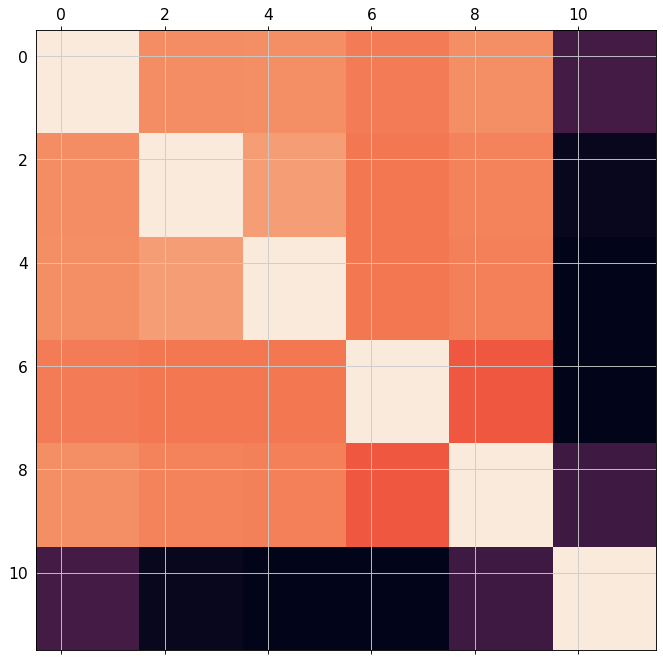

In [54]:
import matplotlib.pyplot as plt

X_ = the_ten_old.X.copy()


plt.matshow(np.corrcoef(X_))


<matplotlib.image.AxesImage object at 0x7fb6b87e7ac0>

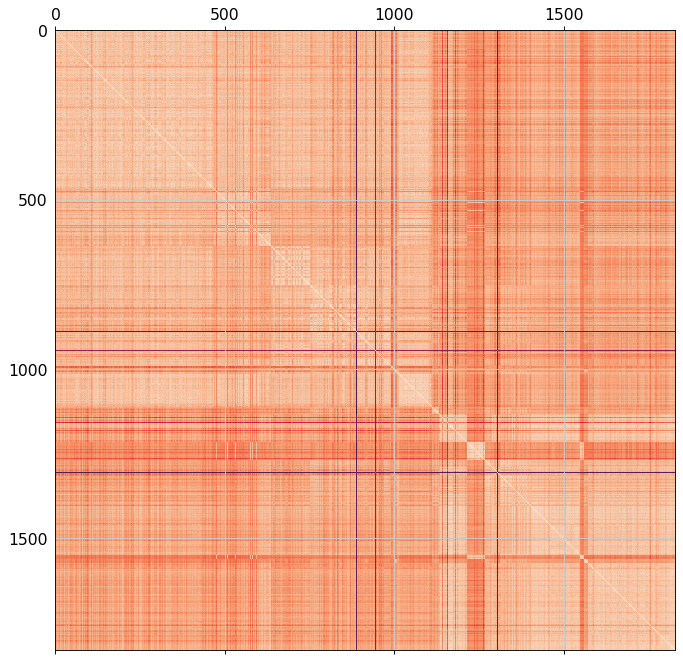

In [55]:
X_total = adata_old.X.copy()

corr_co_eff = np.corrcoef(X_total)

plt.matshow(corr_co_eff) 

<matplotlib.image.AxesImage object at 0x7fb6b874c850>

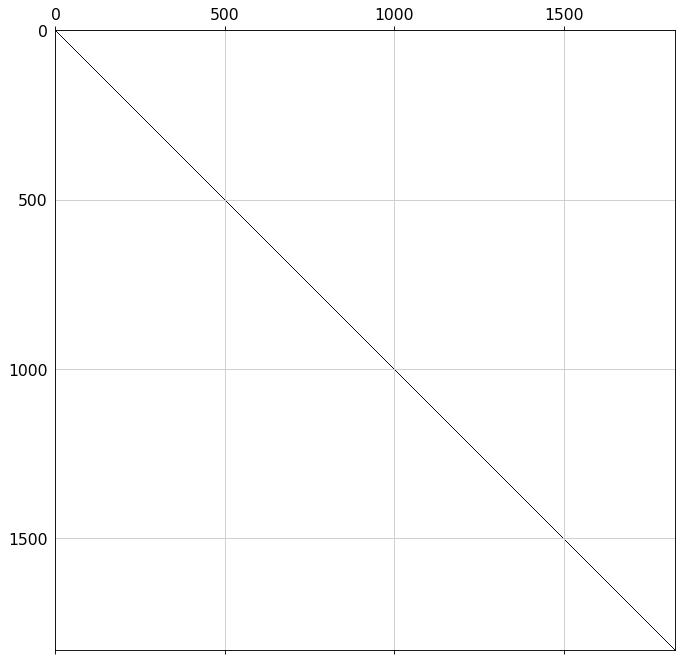

In [56]:
masked = np.ma.masked_not_equal(corr_co_eff, 1)

np.fill_diagonal(masked, 0)

plt.matshow(masked)

In [57]:
print(masked)
print(corr_co_eff)

[[0.0 -- -- ... -- -- --]
 [-- 0.0 -- ... -- -- --]
 [-- -- 0.0 ... -- -- --]
 ...
 [-- -- -- ... 0.0 -- --]
 [-- -- -- ... -- 0.0 --]
 [-- -- -- ... -- -- 0.0]]
[[1.         0.90855703 0.86854886 ... 0.85047541 0.85540798 0.8547429 ]
 [0.90855703 1.         0.8948586  ... 0.87333642 0.86521291 0.8713111 ]
 [0.86854886 0.8948586  1.         ... 0.86933274 0.86977339 0.8704401 ]
 ...
 [0.85047541 0.87333642 0.86933274 ... 1.         0.95466852 0.9664498 ]
 [0.85540798 0.86521291 0.86977339 ... 0.95466852 1.         0.9603132 ]
 [0.8547429  0.8713111  0.8704401  ... 0.9664498  0.9603132  1.        ]]


In [58]:
print(np.ma.masked_not_equal(np.corrcoef(X_), 1.0))

[[-- -- -- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- --]
 [-- -- 1.0 1.0 -- -- -- -- -- -- -- --]
 [-- -- 1.0 1.0 -- -- -- -- -- -- -- --]
 [-- -- -- -- 1.0 1.0 -- -- -- -- -- --]
 [-- -- -- -- 1.0 1.0 -- -- -- -- -- --]
 [-- -- -- -- -- -- 1.0 1.0 -- -- -- --]
 [-- -- -- -- -- -- 1.0 1.0 -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- -- -- -- -- --]]


In [59]:
x_corr = np.corrcoef(X_)

In [60]:
x_corr.astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [61]:
proper_mask = np.where(x_corr <= .9999999999999, x_corr, 1).astype(int)

In [62]:
np.fill_diagonal(proper_mask, 0)

In [63]:
proper_mask

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])